Upload content image:


Saving 233110-New_York_City-USA-city-cityscape-reflection-skyscraper-skyline.jpg to 233110-New_York_City-USA-city-cityscape-reflection-skyscraper-skyline.jpg
Upload style image:


Saving cameron-gould-study-of-the-starry-night-vincent-van-gogh-2400.jpg to cameron-gould-study-of-the-starry-night-vincent-van-gogh-2400.jpg


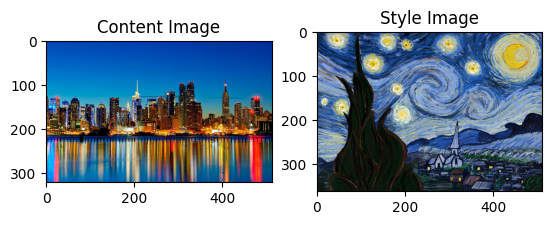

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 362, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 320, 512, 3))
  warnings.warn(msg)


.................................................................................................... Epoch 1 done
.................................................................................................... Epoch 2 done
.................................................................................................... Epoch 3 done
.................................................................................................... Epoch 4 done
.................................................................................................... Epoch 5 done
.................................................................................................... Epoch 6 done
.................................................................................................... Epoch 7 done
.................................................................................................... Epoch 8 done
........................................................................................

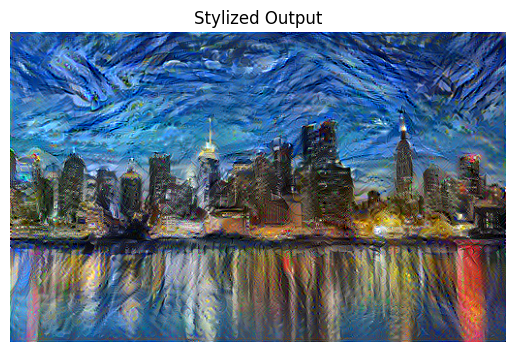

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# ✅ STEP 1: Install and Import Libraries
!pip install -q tensorflow matplotlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time

from tensorflow.keras.preprocessing import image as kp_image

# ✅ STEP 2: Image Loading and Preprocessing
def load_img(path_to_img, max_dim=512):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# ✅ STEP 3: Upload Content and Style Images
from google.colab import files

print("Upload content image:")
uploaded_content = files.upload()
content_path = list(uploaded_content.keys())[0]

print("Upload style image:")
uploaded_style = files.upload()
style_path = list(uploaded_style.keys())[0]

content_image = load_img(content_path)
style_image = load_img(style_path)

# ✅ STEP 4: Display Input Images
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_image(content_image))
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(style_image))
plt.title("Style Image")
plt.show()

# ✅ STEP 5: VGG19 Model and Layer Setup
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# ✅ STEP 6: Style & Content Representation
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# ✅ STEP 7: Extract Features
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# ✅ STEP 8: Define Optimizer and Loss
image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02)

style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_output = outputs['style']
        content_output = outputs['content']

        style_loss = tf.add_n([tf.reduce_mean((style_output[name] - style_targets[name]) ** 2)
                               for name in style_output.keys()])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_output[name] - content_targets[name]) ** 2)
                                 for name in content_output.keys()])
        content_loss *= content_weight / num_content_layers

        loss = style_loss + content_loss

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

# ✅ STEP 9: Run Style Transfer
epochs = 10
steps_per_epoch = 100

step = 0
start = time.time()

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    print(f" Epoch {n+1} done")

end = time.time()
print(f"\nTotal time: {end-start:.1f} seconds")

# ✅ STEP 10: Show Final Output
final_image = tensor_to_image(image)
plt.imshow(final_image)
plt.title("Stylized Output")
plt.axis('off')
plt.show()

# ✅ Save Output
final_image.save("stylized_result.jpg")
files.download("stylized_result.jpg")


Upload content image:


Saving mt-fuji-at-kawaguchiko-lake-in-japan-beautiful-scenic-landscape-of-mountain-fuji-or-fujisan-with-reflection-on-shoji-lake-at-dawn-with-twilight-sky-japan-ai-generated-free-photo.jpg.crdownload to mt-fuji-at-kawaguchiko-lake-in-japan-beautiful-scenic-landscape-of-mountain-fuji-or-fujisan-with-reflection-on-shoji-lake-at-dawn-with-twilight-sky-japan-ai-generated-free-photo.jpg.crdownload
Upload style image:


Saving The_Great_Wave_off_Kanagawa.jpg to The_Great_Wave_off_Kanagawa.jpg


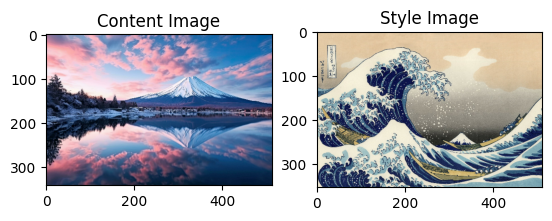

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_66']
Received: inputs=Tensor(shape=(1, 353, 512, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_66']
Received: inputs=Tensor(shape=(1, 341, 512, 3))
  warnings.warn(msg)


.................................................................................................... Epoch 1 done
.................................................................................................... Epoch 2 done
.................................................................................................... Epoch 3 done
.................................................................................................... Epoch 4 done
.................................................................................................... Epoch 5 done
.................................................................................................... Epoch 6 done
.................................................................................................... Epoch 7 done
.................................................................................................... Epoch 8 done
........................................................................................

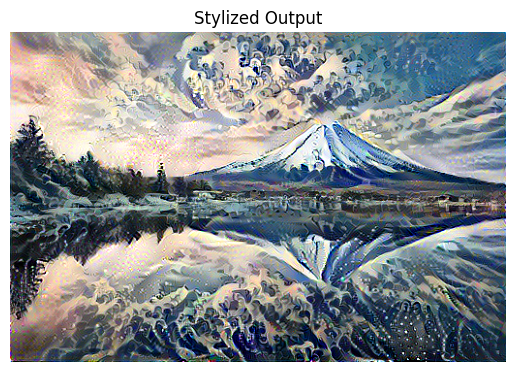

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# ✅ STEP 1: Install and Import Libraries
!pip install -q tensorflow matplotlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time

from tensorflow.keras.preprocessing import image as kp_image

# ✅ STEP 2: Image Loading and Preprocessing
def load_img(path_to_img, max_dim=512):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

# ✅ STEP 3: Upload Content and Style Images
from google.colab import files

print("Upload content image:")
uploaded_content = files.upload()
content_path = list(uploaded_content.keys())[0]

print("Upload style image:")
uploaded_style = files.upload()
style_path = list(uploaded_style.keys())[0]

content_image = load_img(content_path)
style_image = load_img(style_path)

# ✅ STEP 4: Display Input Images
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_image(content_image))
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(style_image))
plt.title("Style Image")
plt.show()

# ✅ STEP 5: VGG19 Model and Layer Setup
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# ✅ STEP 6: Style & Content Representation
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# ✅ STEP 7: Extract Features
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# ✅ STEP 8: Define Optimizer and Loss
image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02)

style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_output = outputs['style']
        content_output = outputs['content']

        style_loss = tf.add_n([tf.reduce_mean((style_output[name] - style_targets[name]) ** 2)
                               for name in style_output.keys()])
        style_loss *= style_weight / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_output[name] - content_targets[name]) ** 2)
                                 for name in content_output.keys()])
        content_loss *= content_weight / num_content_layers

        loss = style_loss + content_loss

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

# ✅ STEP 9: Run Style Transfer
epochs = 10
steps_per_epoch = 100

step = 0
start = time.time()

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    print(f" Epoch {n+1} done")

end = time.time()
print(f"\nTotal time: {end-start:.1f} seconds")

# ✅ STEP 10: Show Final Output
final_image = tensor_to_image(image)
plt.imshow(final_image)
plt.title("Stylized Output")
plt.axis('off')
plt.show()

# ✅ Save Output
final_image.save("stylized_result.jpg")
files.download("stylized_result.jpg")
